In [2]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

In [50]:
bureau = pd.read_csv('../data/bureau.csv')
bb = pd.read_csv('../data/bureau_balance.csv')

In [51]:
train = pd.read_csv('../data/application_train.csv', index_col=0)

# MERGE DATA

In [52]:
bureau_agg = pd.merge(bureau, train[['SK_ID_CURR', 'TARGET']], on='SK_ID_CURR', how='left')
bureau_agg.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629,0.0
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629,0.0
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629,0.0
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629,0.0
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629,0.0


In [53]:
bureau_and_bb = pd.merge(bureau_agg, bb, on='SK_ID_BUREAU', how='left')

In [54]:
bureau_and_bb.head()

,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,SK_ID_CURR,TARGET,MONTHS_BALANCE,STATUS
0,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,254629,0.0,NaN,NaN
1,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,254629,0.0,NaN,NaN
2,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,254629,0.0,NaN,NaN
3,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,254629,0.0,NaN,NaN
4,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,254629,0.0,NaN,NaN


In [55]:
def display_missing_data_info(dataframe):
    missing_values_count = dataframe.isnull().sum()
    missing_values_percentage = (dataframe.isnull().mean() * 100)
    missing_data = pd.DataFrame({
        'Missing Values': missing_values_count,
        'Percentage (%)': missing_values_percentage
    })
    
    missing_data = missing_data[missing_data['Missing Values'] > 0]
    
    sorted_missing_data = missing_data.sort_values(by='Missing Values')

    print(sorted_missing_data)
    


In [56]:
display_missing_data_info(bureau)


                        Missing Values  Percentage (%)
AMT_CREDIT_SUM                       2        0.000191
DAYS_CREDIT_ENDDATE              63604        6.065756
AMT_CREDIT_SUM_DEBT             161599       15.411296
AMT_CREDIT_SUM_LIMIT            355108       33.865770
DAYS_ENDDATE_FACT               383573       36.580407
AMT_CREDIT_MAX_OVERDUE          680861       64.932027
AMT_ANNUITY                     796710       75.980259


# AMT_ANNUITY  

+ Drop AMT_ANNUITY vì giá trị missing quá lớn (75.9 %) và biến này không có tác dụng gì với các biến khác trong bảng bureau and bureau balance, ngoài ra biến ATM_ANNUITY cũng có trong bảng application

In [57]:
bureau_and_bb.drop(labels=["AMT_ANNUITY"],axis=1, inplace= True)

# HANDLE MISSING VALUES

In [58]:
bureau_and_bb['AMT_CREDIT_SUM'].fillna(bureau_and_bb['AMT_CREDIT_SUM'].median(), inplace=True)
bureau_and_bb['DAYS_CREDIT_ENDDATE'].fillna(bureau_and_bb['DAYS_CREDIT_ENDDATE'].median(), inplace=True)
bureau_and_bb['AMT_CREDIT_SUM_DEBT'].fillna(0, inplace=True)   # giả sử missing values là các khoản vay đã được thay toán hoàn toàn
bureau_and_bb['AMT_CREDIT_SUM_LIMIT'].fillna(0, inplace=True)  # giả sử cmissing values là những người không có giới hạn tín dụng 
bureau_and_bb['DAYS_ENDDATE_FACT'].fillna(99999, inplace=True) # giả sử missing values là các khoản vay vẫn còn đang hoạt đôngj
bureau_and_bb['AMT_CREDIT_MAX_OVERDUE'].fillna(0, inplace=True) # giả sử missing values là các khoản vay không có lịch sử quá hạn thanh toán

# FUNCTION

In [59]:
def plot_count_by_target_bar(df, columns, target):
    for col in columns:
        plt.figure(figsize=(10, 6)) 
        sns.countplot(data=df, x=col, hue=target)
        plt.xticks(rotation=45)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [60]:
def plot_count_by_target_barh(df, columns, target):
    for col in columns:
        plt.figure(figsize=(9, 6)) 
        order = df[col].value_counts().index
        sns.countplot(data=df, y=col, hue=target, order=order)
        plt.xlabel('Count')
        plt.ylabel(col)
        plt.title(f'Count of {col} by {target}')
        plt.legend(title=target)
        plt.show()

In [61]:
def plot_count_distribution(dataframe, data_column, title=None, x_label=None, y_label=None):
    plt.figure(figsize=(10, 6))
    sns.countplot(y=data_column, data=dataframe, order=dataframe[data_column].value_counts().index)
    
    if title is None:
        title = f'Distribution of {data_column}'
    plt.title(title)
    
    if x_label is None:
        x_label = 'Count'
    plt.xlabel(x_label)
    
    if y_label is None:
        y_label = data_column
    plt.ylabel(y_label)
    
    plt.show()


## Categorical variables

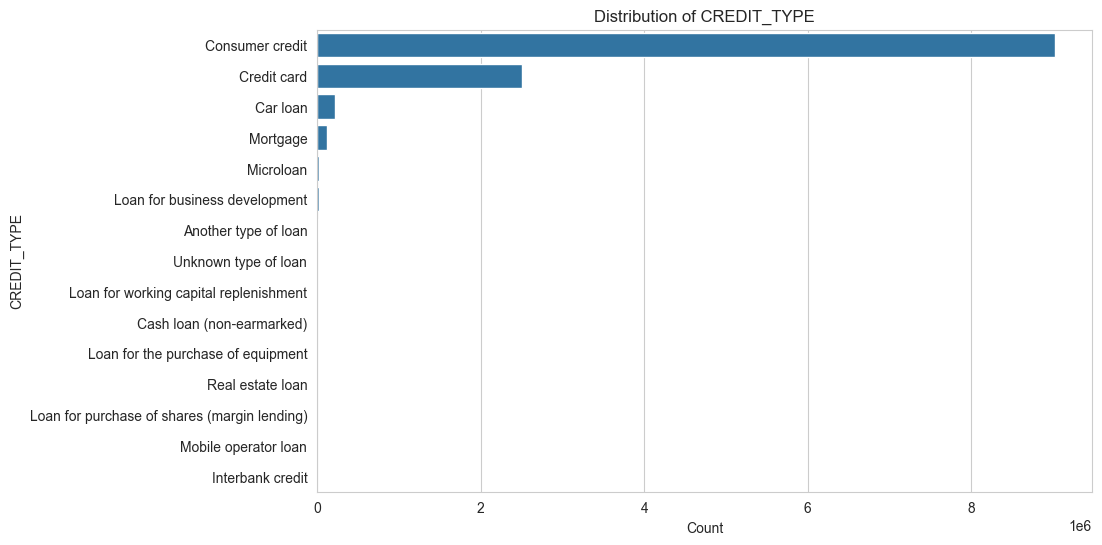

In [62]:
plot_count_distribution(bureau_and_bb, 'CREDIT_TYPE')

The column 'CREDIT_TYPE' contains many different types of credit, but some types appear only a few times. To simplify the data and avoid issues when some credit types have too little information for analysis, replace all credit types with a single category 'Rare', except for 'Consumer credit' and 'Credit card'.

In [63]:
bureau_and_bb['CREDIT_TYPE'] = bureau_and_bb['CREDIT_TYPE'].replace(['Car loan',
            'Mortgage',
            'Microloan',
            'Loan for business development', 
            'Another type of loan',
            'Unknown type of loan', 
            'Loan for working capital replenishment',
            "Loan for purchase of shares (margin lending)",                                                
            'Cash loan (non-earmarked)', 
            'Real estate loan',
            "Loan for the purchase of equipment", 
            "Interbank credit", 
            "Mobile operator loan"], 'Rare')

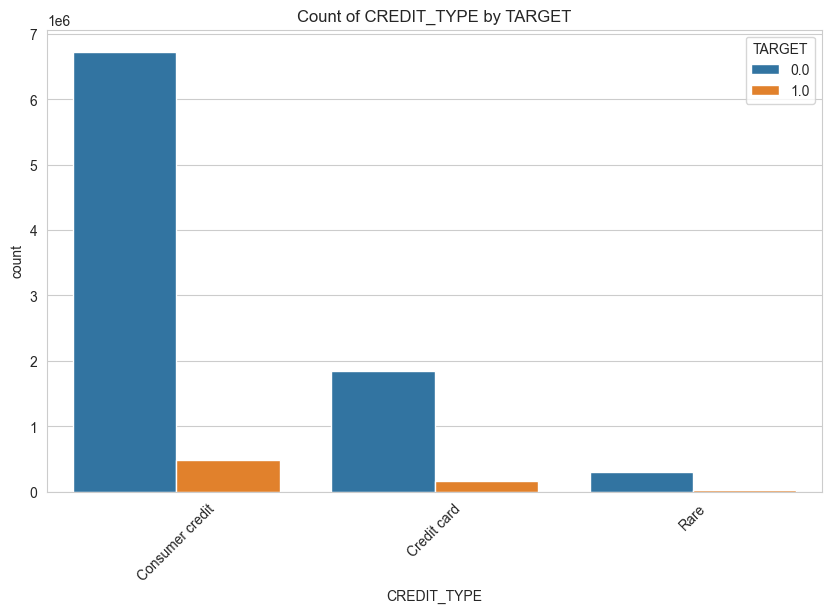

In [64]:
plot_count_by_target_bar(bureau_and_bb, ['CREDIT_TYPE'], 'TARGET')

# CREDIT ACTIVE

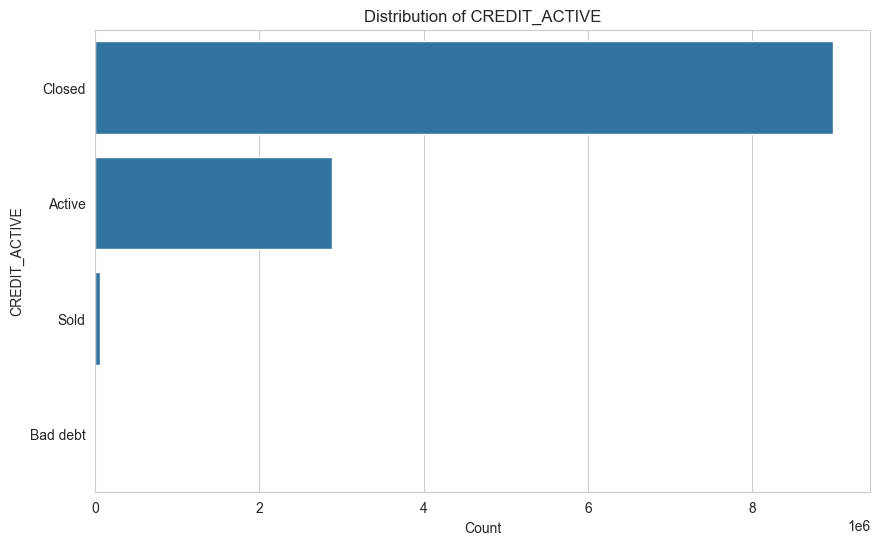

In [65]:
plot_count_distribution(bureau_and_bb, 'CREDIT_ACTIVE')

+ The column 'CREDIT_ACTIVE' has 4 values: 'Active', 'Closed', 'Bad debt', and 'Sold'.
+ 'Bad debt' and 'Sold' are not very relevant to the column, so replace 'Bad debt' and 'Sold' with 'Active'.


In [66]:
bureau_and_bb['CREDIT_ACTIVE'] = bureau_and_bb['CREDIT_ACTIVE'].replace(['Bad debt','Sold'], 'Active')

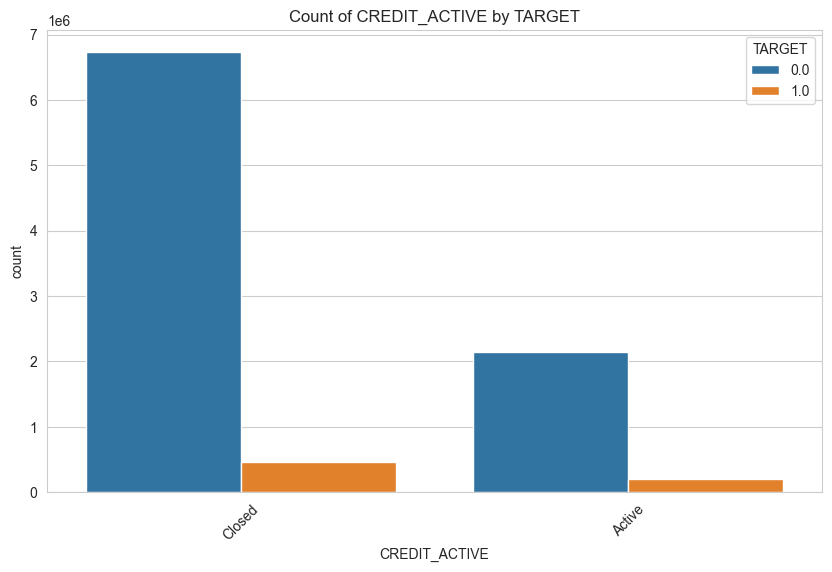

In [67]:
plot_count_by_target_bar(bureau_and_bb, ['CREDIT_ACTIVE'], 'TARGET')

# CREDIT CURRENCY

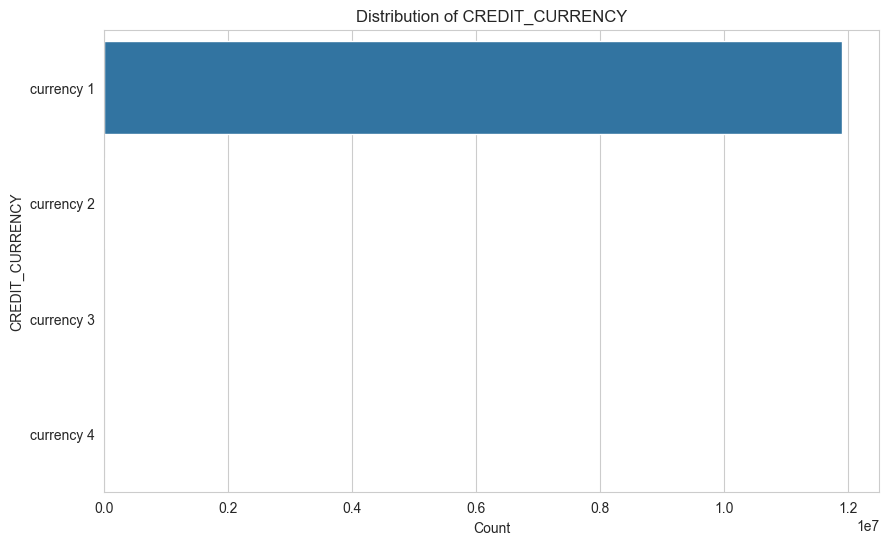

In [68]:
plot_count_distribution(bureau_and_bb, 'CREDIT_CURRENCY')


To delete the columns 'SK_ID_BUREAU' and 'CREDIT_CURRENCY' from the dataframe because the 'CREDIT_CURRENCY' column has 99.9% of its values as 'currency 1',  and the 'SK_ID_BUREAU' column is no longer important for analysis.

In [69]:
bureau_and_bb.drop(["SK_ID_BUREAU","CREDIT_CURRENCY"], inplace = True, axis = 1)

# NUMERICAL VARIABLE

In [70]:
def plot_histogram(data, column, hue="TARGET", bins=None, kde=True):
    if bins is None:
        num_bins = int(1 + np.log2(len(data)))
    else:
        num_bins = bins
    sns.histplot(data=data, x=column, hue=hue, bins=num_bins, kde=kde)

In [71]:
def draw_distribution_dist(x, title,c):
    fig, ax = plt.subplots(2,1,figsize=(10,5))

    sns.distplot(x,ax=ax[0],color=c)
    ax[0].set(xlabel=None)
    ax[0].set_title('Histogram + KDE')

    sns.boxplot(x, ax=ax[1],color=c)
    ax[1].set(xlabel=None)
    ax[1].set_title('Boxplot')

    fig.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

In [72]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'countplot', 'box'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''
    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='blue')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='red')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot, palette={'0.0': 'blue', '1.0': 'red'})
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
                
        if ele == 'countplot':
            sns.countplot(data_to_plot[column_name],hue=data_to_plot['TARGET'])
#             ax.set_xticklabels(ax.get_xticklabels(), rotation= 60)
#             plt.show()

    plt.show()

In [73]:
bureau_and_bb['YEARS_CREDIT'] = abs(bureau_and_bb['DAYS_CREDIT'] / 365)

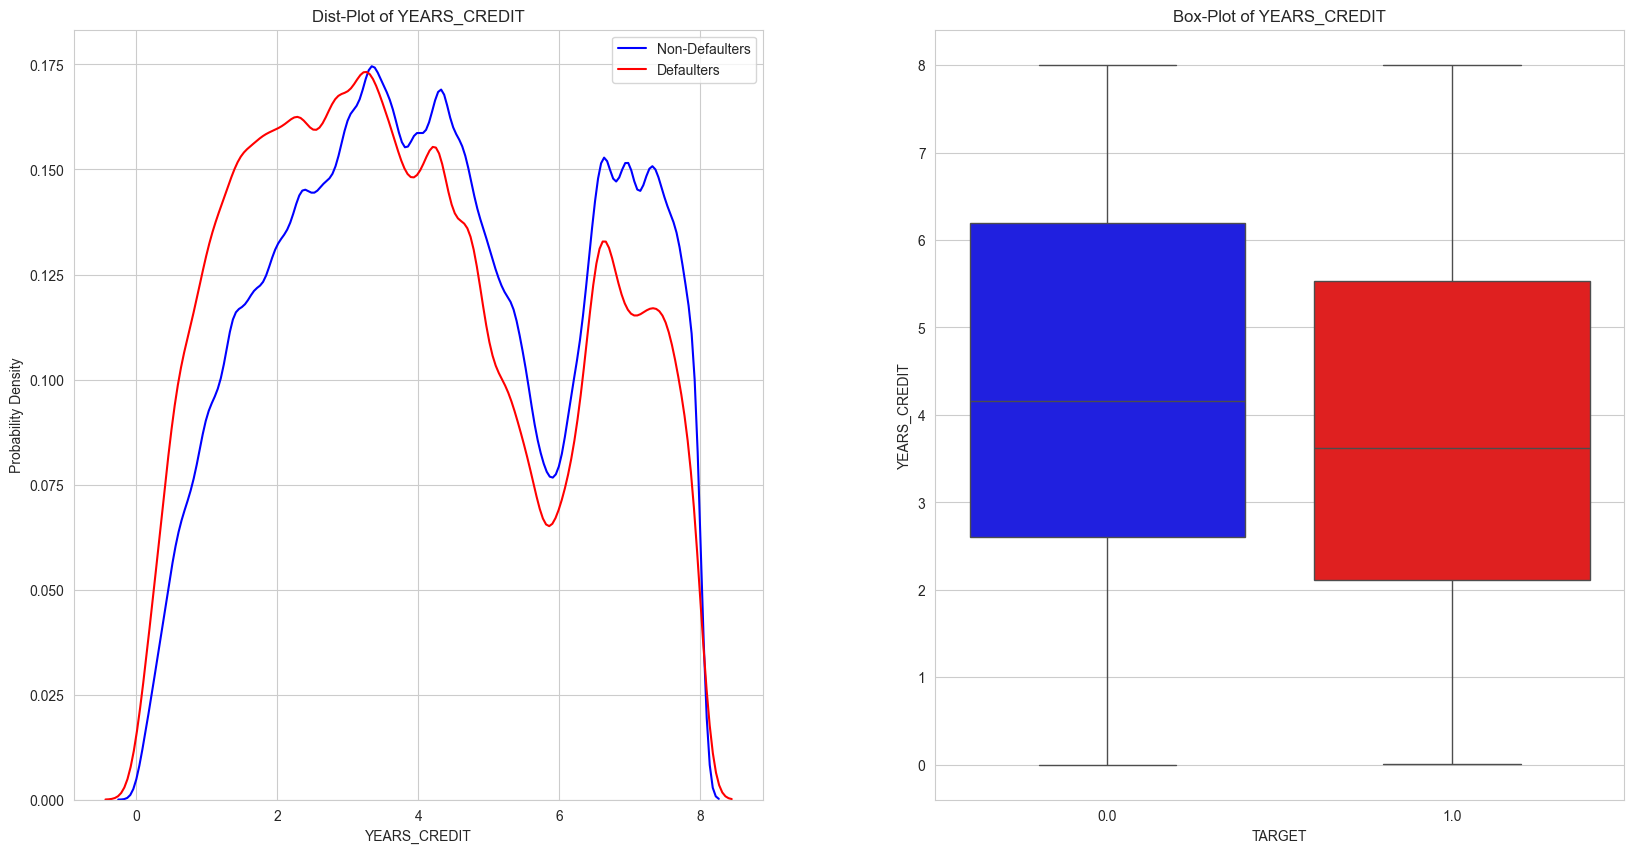

In [74]:
plot_continuous_variables(bureau_and_bb,'YEARS_CREDIT', plots = ['distplot','box'],figsize=(20,10))

+ Both default and non-default individuals have similar credit year distribution, with the peak of the distribution in the same range. 
+ This may indicate that the number of credit years does not provide enough discriminatory power to predict default likelihood.
+ The non-default group has a narrower Interquartile Range (IQR) compared to the default group, which may suggest that non-default individuals typically have a more stable credit history.
+ There is no significant difference in the average number of credit years between the two groups.

# DAYS_CREDIT_ENDDATE

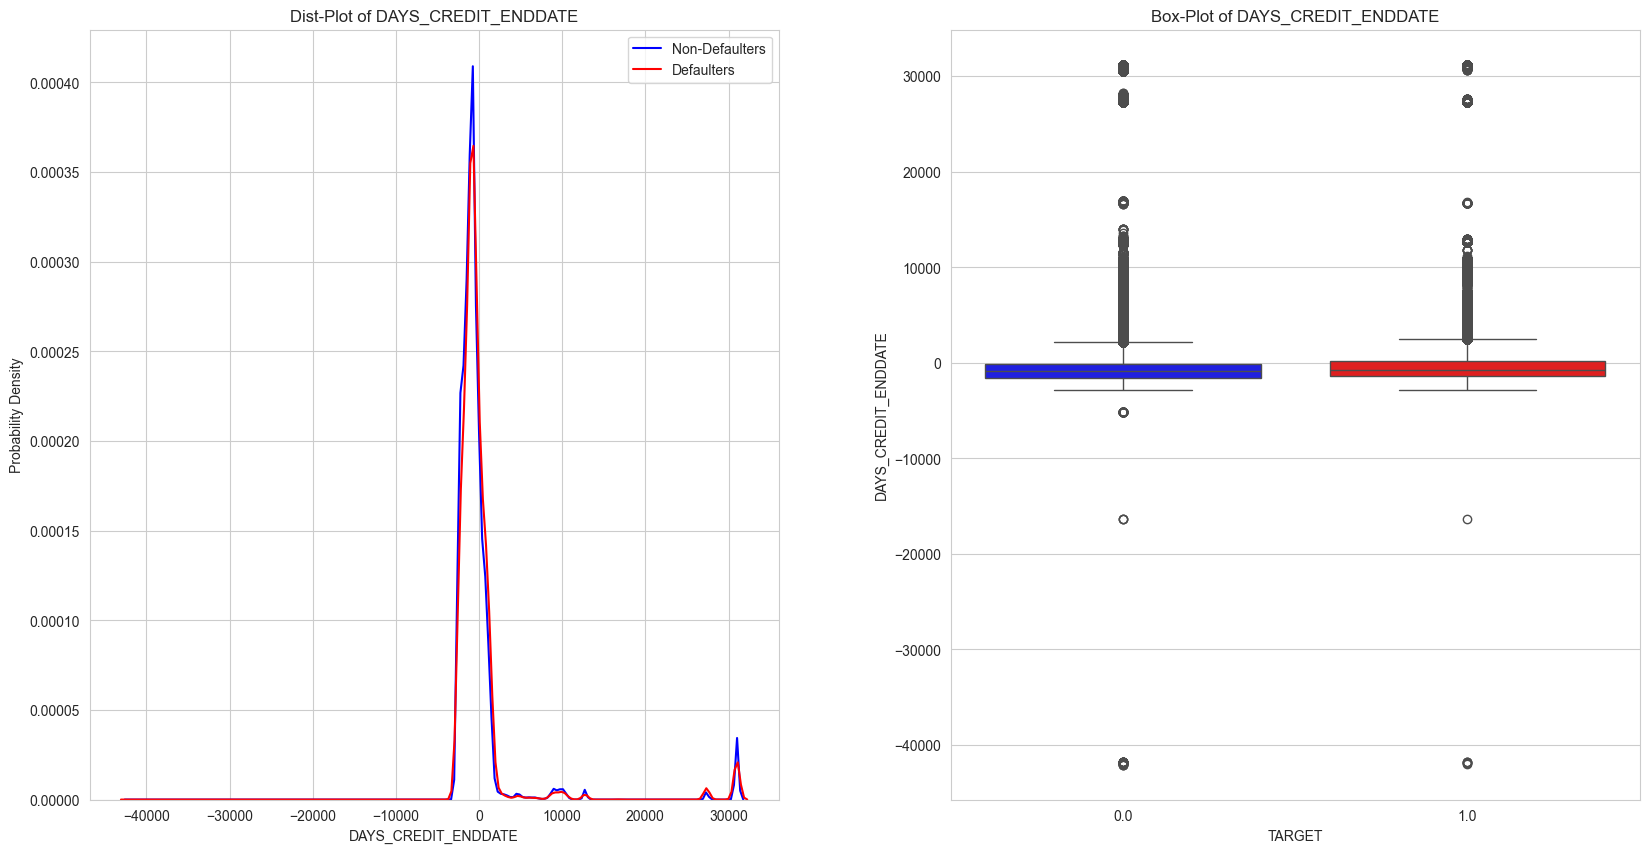

In [75]:
plot_continuous_variables(bureau_and_bb,'DAYS_CREDIT_ENDDATE', plots = ['distplot','box'],figsize=(20,10))

The histogram can't distinguish between classes 1 and 0

In [76]:
credit_active_dummies = pd.get_dummies(bureau_and_bb['CREDIT_ACTIVE'], prefix='CREDIT_ACTIVE')

# Join the dummy variables to the original DataFrame
bureau_and_bb = pd.concat([bureau_and_bb, credit_active_dummies], axis=1)

## BEREAU BALANCE

# STATUS

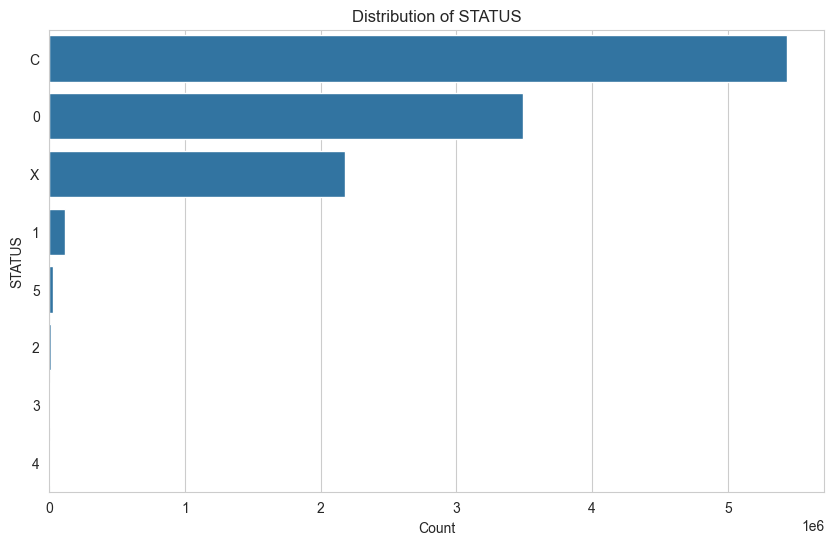

In [77]:
plot_count_distribution(bureau_and_bb, 'STATUS')

In [78]:
status_df = bureau_and_bb.groupby(['SK_ID_CURR', 'TARGET']).agg({'STATUS': 'nunique'}).reset_index()

In [79]:
status_df.head()

,SK_ID_CURR,TARGET,STATUS
0,0,0.0,0
1,1,1.0,2
2,2,0.0,0
3,6,0.0,0
4,7,0.0,0


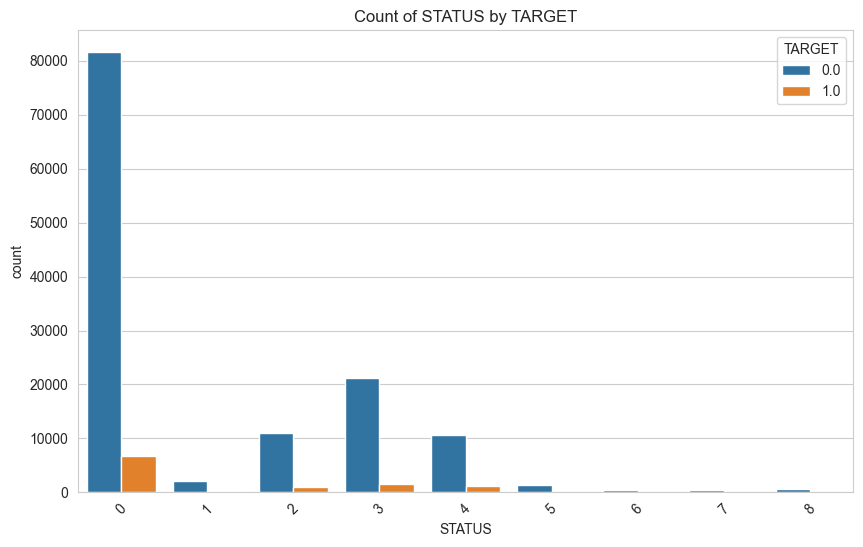

In [80]:
plot_count_by_target_bar(status_df, ['STATUS'], 'TARGET')

In [85]:
df_copy = bureau_and_bb.copy()

df_dummies = pd.get_dummies(df_copy['STATUS'], prefix='STATUS', dummy_na=True)

selected_dummies = df_dummies[['STATUS_0', 'STATUS_C']]

bureau_and_bb = pd.concat([bureau_and_bb, selected_dummies], axis=1)


In [97]:
status_0_sum_df = bureau_and_bb.groupby(['SK_ID_CURR', 'TARGET'])['STATUS_0'].sum().reset_index()

In [98]:
status_0_sum_df

,SK_ID_CURR,TARGET,STATUS_0
0,0,0.0,0
1,1,1.0,10
2,2,0.0,0
3,6,0.0,0
4,7,0.0,0
...,...,...,...
140244,307501,0.0,17
140245,307504,0.0,0
140246,307505,0.0,15
140247,307506,0.0,0


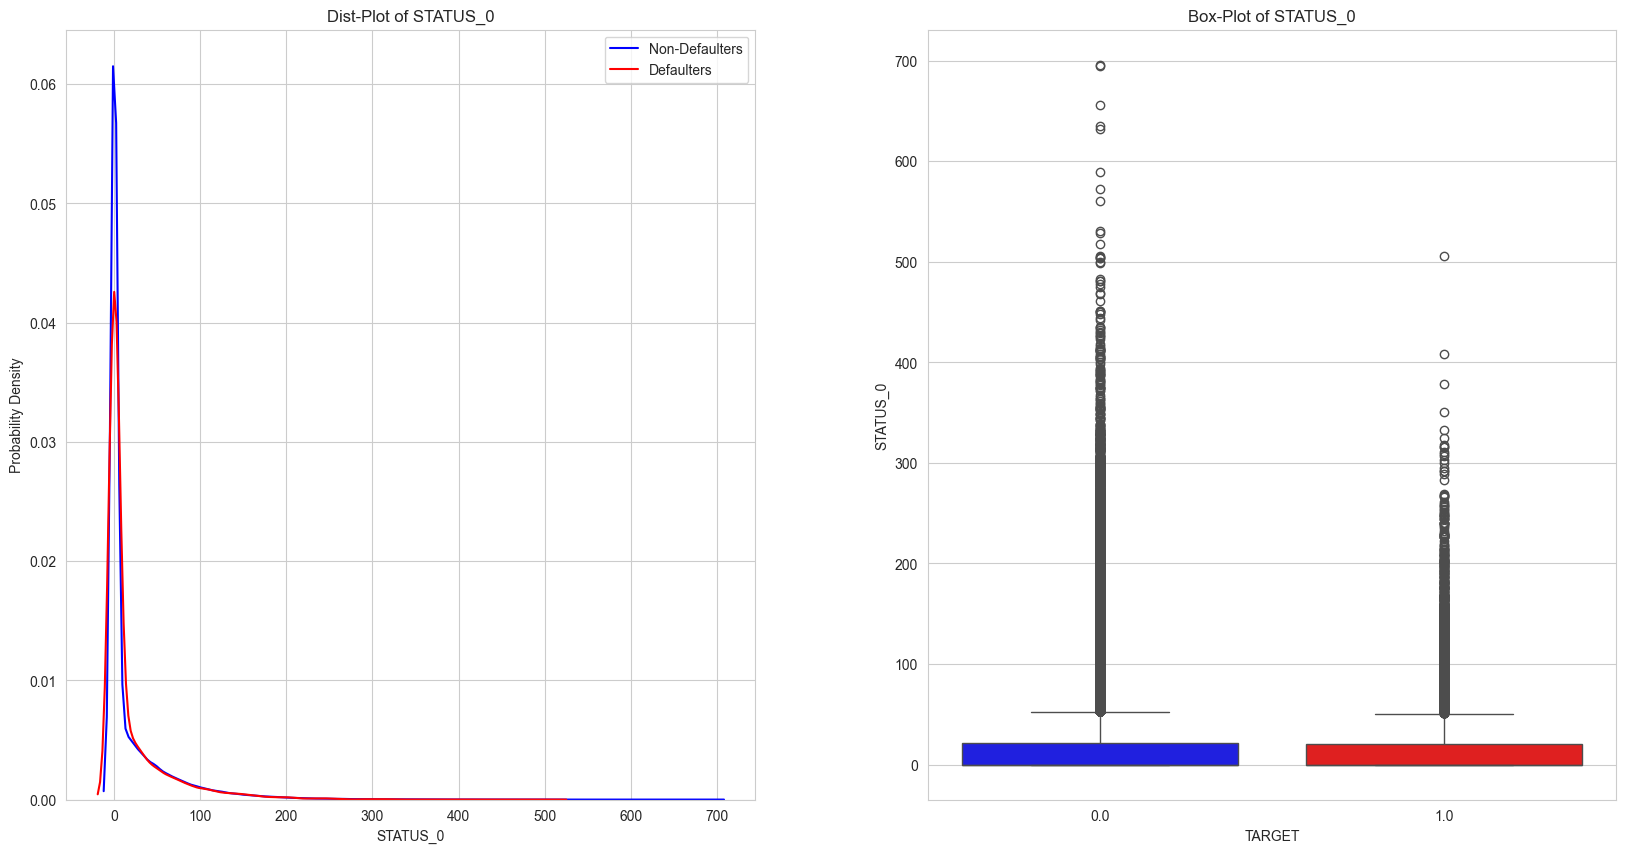

In [99]:
plot_continuous_variables(status_0_sum_df ,'STATUS_0', plots = ['distplot','box'],figsize=(20,10))

# MONTHS_BALANCE

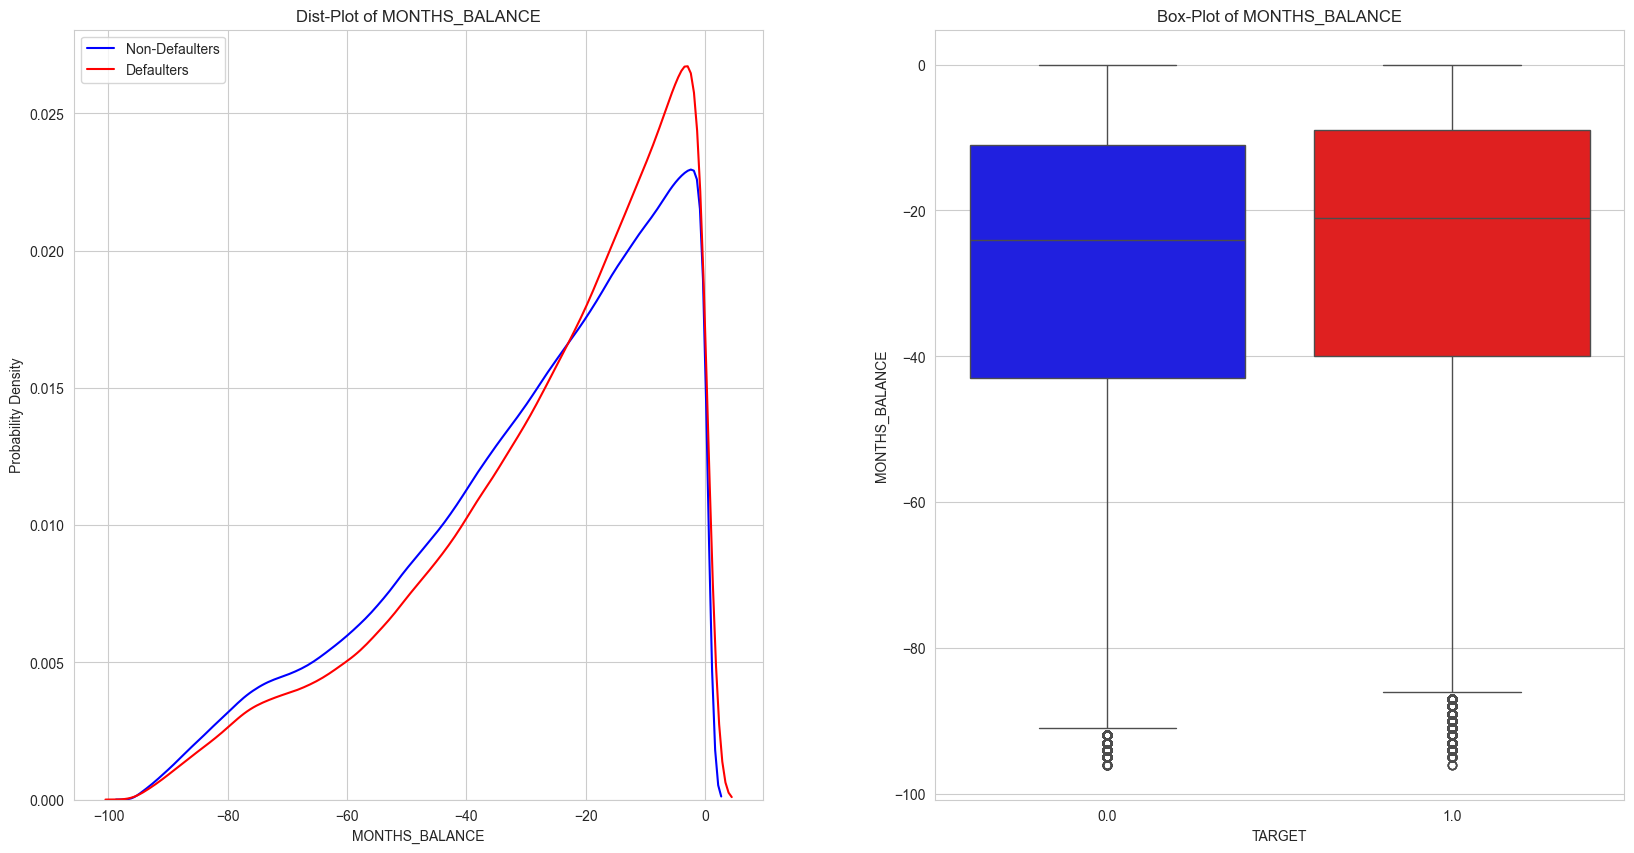

In [31]:
plot_continuous_variables(bureau_and_bb, 'MONTHS_BALANCE', plots=['distplot','box'], figsize=(20,10))


+ Both charts show that there is no clear distinction between the defaulters and non-defaulters groups based on the "MONTHS_BALANCE" value alone. Both groups have similar distributions, and their medians are almost identical.

+ There is a high degree of overlap between the two groups, indicating that "MONTHS_BALANCE" may not be a strong independent variable for predicting a customer's likelihood of default.